In [ ]:
Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


Load and Inspect Data

In [2]:
columns = [
    "status", "duration", "credit_history", "purpose", "credit_amount", "savings",
    "employment", "installment_rate", "personal_status_sex", "guarantors",
    "residence_duration", "property", "age", "other_installment_plans", "housing",
    "number_credits", "job", "people_liable", "telephone", "foreign_worker", "target"
]

df = pd.read_csv('german.data', sep=' ', header=None, names=columns)
print("Shape:", df.shape)
print(df.head())
print("\nTarget distribution:\n", df['target'].value_counts())


Shape: (1000, 21)
  status  duration credit_history purpose  credit_amount savings employment  \
0    A11         6            A34     A43           1169     A65        A75   
1    A12        48            A32     A43           5951     A61        A73   
2    A14        12            A34     A46           2096     A61        A74   
3    A11        42            A32     A42           7882     A61        A74   
4    A11        24            A33     A40           4870     A61        A73   

   installment_rate personal_status_sex guarantors  ...  property age  \
0                 4                 A93       A101  ...      A121  67   
1                 2                 A92       A101  ...      A121  22   
2                 2                 A93       A101  ...      A121  49   
3                 2                 A93       A103  ...      A122  45   
4                 3                 A93       A101  ...      A124  53   

   other_installment_plans housing number_credits   job people_liabl

 Data Cleaning and Feature Engineering

In [3]:
# Check for missing values
print("\nMissing values:\n", df.isnull().sum())

# Create a new feature: credit per month
df['credit_per_month'] = df['credit_amount'] / df['duration']
print("\nSample with new feature:\n", df[['credit_amount', 'duration', 'credit_per_month']].head())



Missing values:
 status                     0
duration                   0
credit_history             0
purpose                    0
credit_amount              0
savings                    0
employment                 0
installment_rate           0
personal_status_sex        0
guarantors                 0
residence_duration         0
property                   0
age                        0
other_installment_plans    0
housing                    0
number_credits             0
job                        0
people_liable              0
telephone                  0
foreign_worker             0
target                     0
dtype: int64

Sample with new feature:
    credit_amount  duration  credit_per_month
0           1169         6        194.833333
1           5951        48        123.979167
2           2096        12        174.666667
3           7882        42        187.666667
4           4870        24        202.916667


 Encode Target and Categorical Variables

In [4]:
# Encode target: 1 (good) -> 0, 2 (bad) -> 1
df['target'] = df['target'].map({1: 0, 2: 1})
print("\nEncoded target distribution:\n", df['target'].value_counts())

# One-hot encode categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
print("\nEncoded DataFrame shape:", df_encoded.shape)
print(df_encoded.head())



Encoded target distribution:
 target
0    700
1    300
Name: count, dtype: int64

Encoded DataFrame shape: (1000, 50)
   duration  credit_amount  installment_rate  residence_duration  age  \
0         6           1169                 4                   4   67   
1        48           5951                 2                   2   22   
2        12           2096                 2                   3   49   
3        42           7882                 2                   4   45   
4        24           4870                 3                   4   53   

   number_credits  people_liable  target  credit_per_month  status_A12  ...  \
0               2              1       0        194.833333       False  ...   
1               1              1       1        123.979167        True  ...   
2               1              2       0        174.666667       False  ...   
3               1              2       0        187.666667       False  ...   
4               2              2       1       

Train/Test Split and Scaling

In [5]:
X = df_encoded.drop('target', axis=1)
y = df_encoded['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

# Scale features for models that benefit from it
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Train shape: (800, 49) Test shape: (200, 49)


Model Building

A. Logistic Regression

In [6]:
lr = LogisticRegression(max_iter=1000, solver='liblinear')
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
y_proba_lr = lr.predict_proba(X_test_scaled)[:, 1]
print("\nLogistic Regression Results:")
print(classification_report(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))



Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.83      0.86      0.84       140
           1       0.64      0.58      0.61        60

    accuracy                           0.78       200
   macro avg       0.73      0.72      0.73       200
weighted avg       0.77      0.78      0.77       200

ROC-AUC: 0.8014285714285715
Confusion Matrix:
 [[120  20]
 [ 25  35]]


B. Random Forest

In [7]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]
print("\nRandom Forest Results:")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))



Random Forest Results:
              precision    recall  f1-score   support

           0       0.78      0.96      0.86       140
           1       0.79      0.38      0.52        60

    accuracy                           0.79       200
   macro avg       0.79      0.67      0.69       200
weighted avg       0.79      0.79      0.76       200

ROC-AUC: 0.7756547619047619
Confusion Matrix:
 [[134   6]
 [ 37  23]]


Feature Importance

A. Logistic Regression

In [8]:
lr_importances = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': lr.coef_[0]
}).sort_values(by='coefficient', key=abs, ascending=False)
print("\nTop Logistic Regression Features:\n", lr_importances.head(10))



Top Logistic Regression Features:
                     feature  coefficient
10               status_A14    -0.778845
14       credit_history_A34    -0.636671
33  personal_status_sex_A93    -0.484862
39            property_A124     0.449867
43             housing_A153    -0.436409
27              savings_A65    -0.425322
15              purpose_A41    -0.399933
2          installment_rate     0.393462
30           employment_A74    -0.367473
0                  duration     0.346045


B. Random Forest


Top Random Forest Features:
                          feature  importance
1                  credit_amount    0.105077
7               credit_per_month    0.101382
4                            age    0.080242
0                       duration    0.079053
10                    status_A14    0.078274
2               installment_rate    0.033996
3             residence_duration    0.032522
14            credit_history_A34    0.028483
41  other_installment_plans_A143    0.022946
27                   savings_A65    0.020330


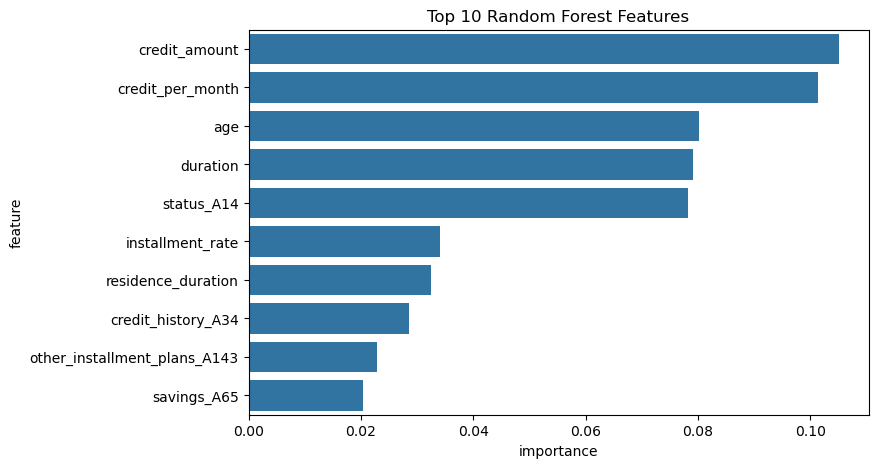

In [9]:
rf_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf.feature_importances_
}).sort_values(by='importance', ascending=False)
print("\nTop Random Forest Features:\n", rf_importances.head(10))

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x='importance', y='feature', data=rf_importances.head(10))
plt.title('Top 10 Random Forest Features')
plt.show()


Save Model for Deployment

In [10]:
import joblib
joblib.dump(rf, 'credit_scoring_rf_model.pkl')
joblib.dump(scaler, 'credit_scoring_scaler.pkl')
joblib.dump(X_train.columns.tolist(), 'credit_scoring_features.pkl')
print("Model and scaler saved.")


Model and scaler saved.


Predict on New Data (Optional/Advanced)

In [11]:
def score_applicant(applicant_dict):
    applicant_df = pd.DataFrame([applicant_dict])
    applicant_encoded = pd.get_dummies(applicant_df)
    for col in X_train.columns:
        if col not in applicant_encoded.columns:
            applicant_encoded[col] = 0
    applicant_encoded = applicant_encoded[X_train.columns]
    applicant_scaled = scaler.transform(applicant_encoded)
    applicant_scaled_df = pd.DataFrame(applicant_scaled, columns=X_train.columns)
    prediction = rf.predict(applicant_scaled_df)
    probability = rf.predict_proba(applicant_scaled_df)[0, 1]
    return {"prediction": "Bad" if prediction[0] else "Good", "probability": probability}

# Example usage
new_applicant = {
    "status": "A11", "duration": 12, "credit_history": "A34", "purpose": "A43",
    "credit_amount": 2500, "savings": "A61", "employment": "A75", "installment_rate": 2,
    "personal_status_sex": "A93", "guarantors": "A101", "residence_duration": 3,
    "property": "A121", "age": 35, "other_installment_plans": "A143", "housing": "A152",
    "number_credits": 1, "job": "A173", "people_liable": 1, "telephone": "A192", "foreign_worker": "A201",
    "credit_per_month": 208.33
}
print(score_applicant(new_applicant))


{'prediction': 'Good', 'probability': 0.2}


In [2]:
import joblib
joblib.dump(rf, 'credit_scoring_rf_model.pkl')


NameError: name 'rf' is not defined

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import joblib

# Load data
columns = [
    "status", "duration", "credit_history", "purpose", "credit_amount", "savings",
    "employment", "installment_rate", "personal_status_sex", "guarantors",
    "residence_duration", "property", "age", "other_installment_plans", "housing",
    "number_credits", "job", "people_liable", "telephone", "foreign_worker", "target"
]
df = pd.read_csv('german.data', sep=' ', header=None, names=columns)

# Encode target
df['target'] = df['target'].map({1: 0, 2: 1})

# One-hot encode categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Split data
X = df_encoded.drop('target', axis=1)
y = df_encoded['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)

# Save model
joblib.dump(rf, 'credit_scoring_rf_model.pkl')

# Verify file saved
import os
print([f for f in os.listdir() if f.endswith('.pkl')])


['credit_scoring_rf_model.pkl']
